In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#import csv with id column as index
df = pd.read_csv('applestore.csv', index_col=0)

#taking only the columns we'll be using for analysis
df = df[['track_name', 'prime_genre', 'price', 'user_rating']]

In [4]:
#creating a new dataframe and setting its index to unique values of prime_genre
newdf = pd.DataFrame(index=df['prime_genre'].value_counts().index)

#joining to new dataframe a column with total number of apps for each genre
newdf = newdf.join(df['prime_genre'].value_counts())

#renaming that new column total_of_apps
newdf.rename(columns={"prime_genre":"total_of_apps"}, inplace=True)

In [5]:
#creating a new dataframe to store paid apps. doing it this way because it's easier to analyze its data eg: df.describe
dfpaid = df[df['price'] != 0]
#checking if its correct
#dfpaid['prime_genre'].value_counts()
#df[(df.prime_genre == 'Games') & (df.price != 0)].describe()

In [6]:
#joining to newdf the number of paid apps for each genre
newdf = newdf.join(dfpaid['prime_genre'].value_counts())

In [7]:
#creating another dataframe to manip the total price values.
#setting its index the same as newdf because we'll be joining columns later.
tot_price = pd.DataFrame(index = newdf.index)

#creating a column full of zeros, those of which will be used as accumulators
tot_price['value'] = np.zeros((23, 1))

In [8]:
#iterating over all apps on df and adding/summing values to their respective genres
for index, row in df.iterrows():
    if row.price != 0:
        tot_price.value[row.prime_genre] += row.price
        
#joining the final column with sum of prices to newdf.
newdf = newdf.join(tot_price)

In [9]:
#just renaming
newdf.rename(columns={"prime_genre":"paid_apps"}, inplace=True)
newdf.rename(columns={"value":"bulk_price"}, inplace=True)

In [10]:
#creating the avg. price column by dividing total of price by total of paid apps
newdf['avg_price'] = newdf['bulk_price'] / newdf['paid_apps']

In [11]:
#using the same analogy of tot_price, but now for ratings.
tot_rating = pd.DataFrame(index = newdf.index)
tot_rating['value'] = np.zeros((23, 1))
for index, row in df.iterrows():
    tot_rating.value[row.prime_genre] += row.user_rating
        
newdf = newdf.join(tot_rating)

In [12]:
newdf.rename(columns={"value":"bulk_rating"}, inplace=True)

In [13]:
#testing if the results make sense
#df[(df.prime_genre == 'Games')].mean()

#creating new columns to use
newdf['avg_rating'] = newdf.bulk_rating / newdf.total_of_apps
newdf['free_apps'] = newdf.total_of_apps - newdf.paid_apps

In [14]:
#setting style for seaborn
sns.set_style('white')
sns.set_context({"figure.figsize": (10,24)})

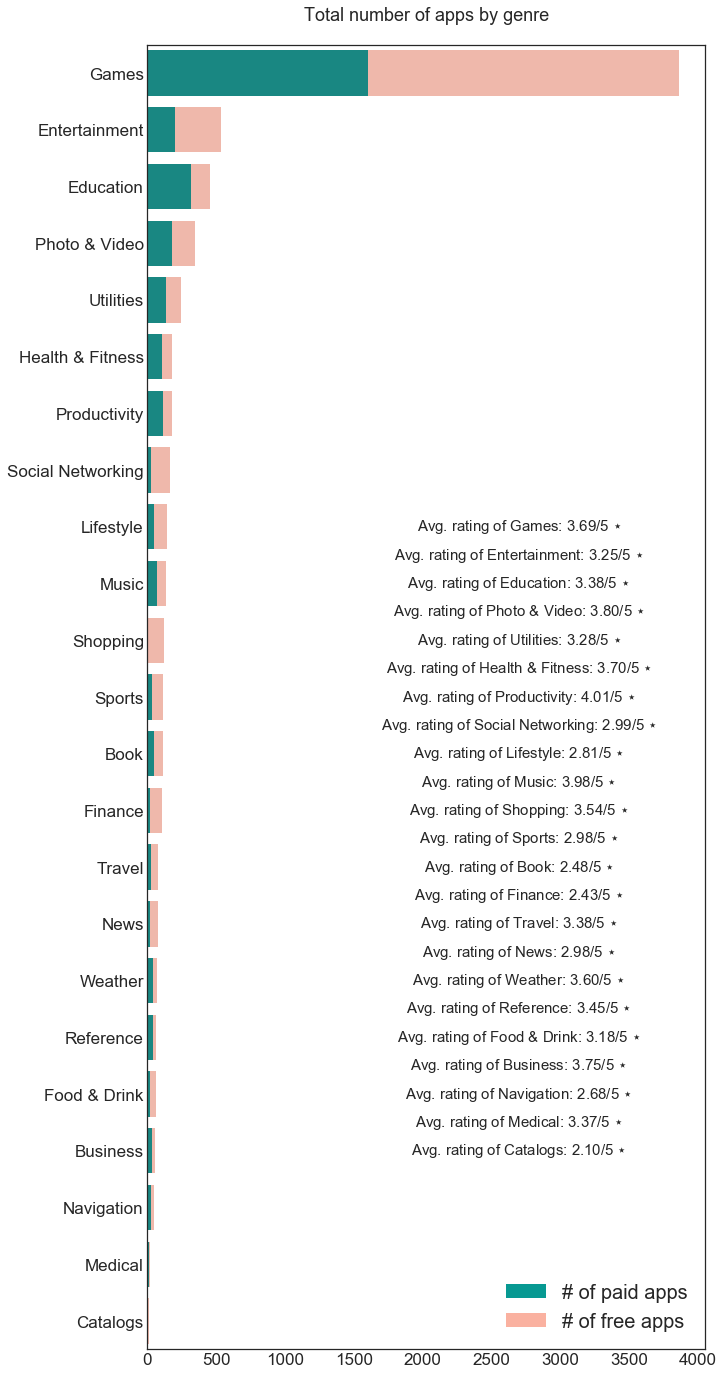

In [20]:
#stacked bar plot is made heavily inspired on this tutorial: https://randyzwitch.com/creating-stacked-bar-chart-seaborn/
#since seaborn doesnt really have a proper way of doing it.
ax1 = sns.barplot(x = newdf.total_of_apps, y = newdf.index, color = "#fab1a0")
bottom_plot = sns.barplot(x = newdf.paid_apps, y = newdf.index, color = "#079992")
topbar = plt.Rectangle((0,0),1,1,fc="#fab1a0", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#079992',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['# of paid apps', '# of free apps'], loc=4, ncol = 1, prop={'size':20})
l.draw_frame(False)
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(17)

#adjusting axis labels and title for the plot
plt.xlabel("")
ax1.set_title('Total number of apps by genre', pad=24, size=18)

#defining the function that prints the avg. rating text for every genre
rects = ax1.patches
def autoannotate(rects):
    for i in range(23):
        s = 'Avg. rating of ' + newdf.index[i] + ': %.2f/5 $\star$' % float(newdf.avg_rating[i])
        plt.text(2700, 8+(i*0.5),
                s, size=15,
                ha='center', va='center')
        i = i + 1
        
#then finally calling it
autoannotate(rects)

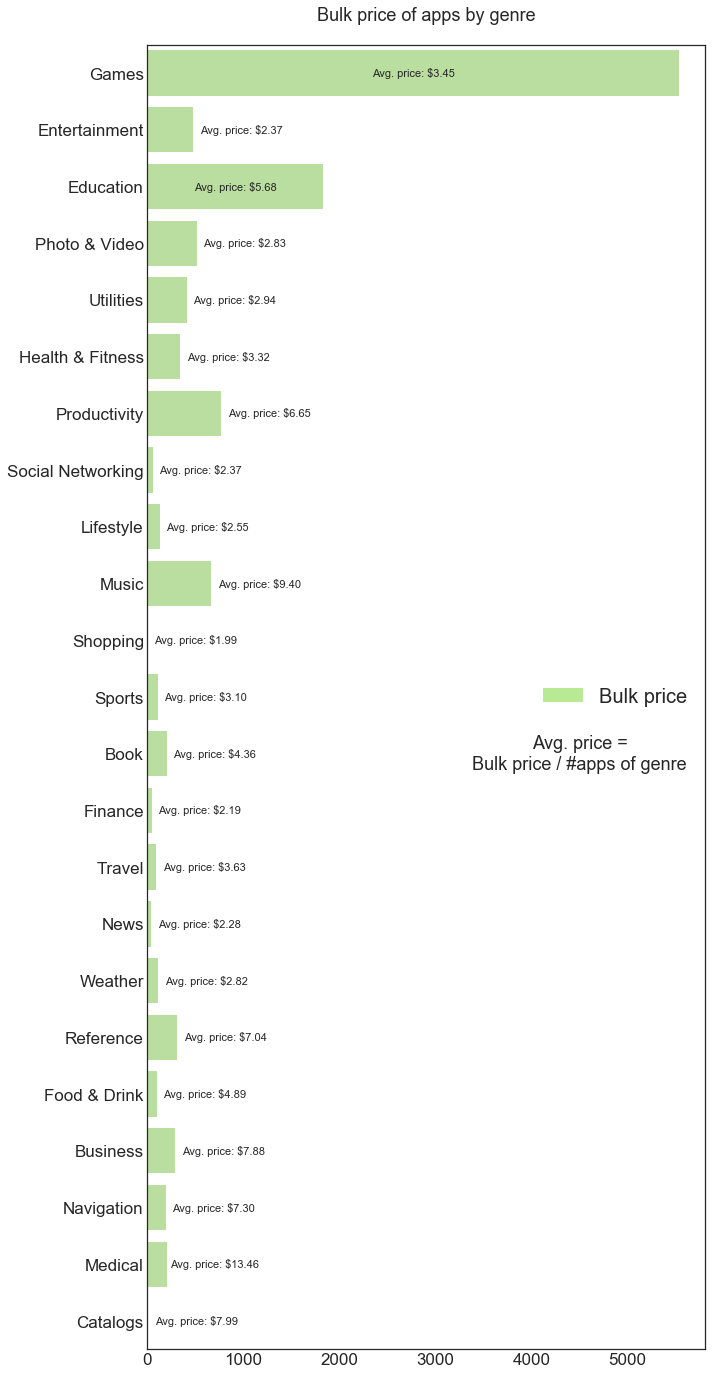

In [21]:
#creating the plot and defining the bars for the autolabel function to use
ax = sns.barplot(x = newdf.bulk_price, y = newdf.index, color = "#b8e994")
rects = ax.patches

#defining a bar variable to refer to the color, and use it as a handle to the legend plot
bar = plt.Rectangle((0,0),1,1,fc="#b8e994", edgecolor = 'none')
plt.legend([bar], ['Bulk price'], loc=7, ncol = 1, prop={'size':20})

for item in ([ax.xaxis.label, ax.yaxis.label] +
            ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(17)

#printing the text that explaing the relation among bulk/avg price and #of apps
plt.text(4500, 12,
                'Avg. price =\nBulk price / #apps of genre', size=18,
                ha='center', va='center')

#adjusting axis labels and title for the plot
plt.xlabel("")
ax.set_title('Bulk price of apps by genre', pad=24, size=18)

#defining the function that labels each bar with its corresponding avg price.
#i had to hard code the text to be inside the bar on the first and the thirds ones, simply bc it fits better.
def autolabel(rects):
    i = 0
    for rect in rects:
        width = rect.get_width()
        if i == 0 or i == 2:
            x = rect.get_width()*0.5
        else:
            x = rect.get_width()+500
        plt.text(x, rect.get_y()+0.5*rect.get_height(),
                'Avg. price: $%.2f' % float(newdf.avg_price[i]),
                ha='center', va='center', size=11)
        i = i + 1
        
#then calling it.
autolabel(rects)